## Solving a inverse heat equation

We want to solve a inverse 2D heat equation and find the heat diffusion coefficent $D$.

In [17]:
import torch
import torchphysics as tp
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use

Like always we first define the spaces. Even if we want to find the value of $D$ we still define a space for this coefficent.

In [23]:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
D = tp.spaces.R1('D') # one dimensional parameter

U = tp.spaces.R1('u')

Next are the domains for space and time

In [24]:
w, h = 10, 10
t_0, t_end = 0, 3
temp_hot = 50

domain_x = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
domain_t = tp.domains.Interval(T, t_0, t_end)

Now we construct the neural network like always, since we will not only find $D$ but also create a *interpolation* of the given data. 

For the parameter that we want to find, we use the class *Parameter*, which gets an inital guess and a spaces as an input. This parameter then has to be passed to the conditions, to be trained. 

In [25]:
# D NOT input of the model:
model = tp.models.FCN(input_space=X*T, output_space=U, hidden=(30,30,30))

param_D = tp.models.Parameter(init=0.0, space=D)

We need some data to use in the inverse problem, for this we create a solution with a FDM scheme.

In [78]:
import sys
sys.path.append('..')

from fdm_heat_equation import FDM, transform_to_points

def inital_value(x):
    return temp_hot*torch.sin(math.pi/w*x[:,0])*torch.sin(math.pi/h*x[:,1])

final_D = 20 # the D value we want to find 
fdm_domain, fdm_time_domains, fdm_solution = FDM([0, w, 0, h], 2*[0.5], [t_0,t_end], [final_D], inital_value)
# transform to correct format for our use:
fdm_inp, fdm_out = transform_to_points(fdm_domain, fdm_time_domains, fdm_solution, [final_D], False)

Now we have around 40.000 data points. But we only want to use a few, so we use random.choice to pick here 5000 points

In [79]:
import numpy as np
index = np.random.choice(len(fdm_inp), 10000, replace=True)
fdm_inp = fdm_inp[index, ]
fdm_out = fdm_out[index, ]

This data we use now to create a data condition that will train the network:

In [80]:
data_loader = tp.utils.PointsDataLoader((fdm_inp, fdm_out), batch_size=10000)
data_condition = tp.conditions.DataCondition(module=model,
                                             dataloader=data_loader,
                                             norm=2, 
                                             use_full_dataset=True) 

To learn the parameter we have to use the PDE itself. Therefore we will create, just like in the forward problem, a condition for the PDE. For this condition we have to pass in the parameter $D$ we created.

In [81]:
inner_sampler = tp.samplers.RandomUniformSampler(domain_x*domain_t, n_points=5000)

def heat_residual(u, x, t, D):
    return D*tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition', 
                                            parameter=param_D) # here pass in the param

This is all we have to do, to define the inverse problem. Now we can already start the training like always and the parameter $D$ will be learned too. We start with Adam:

In [82]:
solver = tp.solver.Solver([pde_condition, data_condition])

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=0,
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 2.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████████████████████████████████████▉| 5000/5001 [03:07<00:00, 26.63it/s, loss=1.98]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████| 5001/5001 [03:07<00:00, 26.63it/s, loss=1.98]


Finally we can have a look on the value of D. Which is pretty close to $D=2.0$, that we used in FDM to create the data.

In [83]:
param_D

Parameter:
{'D': tensor([[9.7377]], grad_fn=<AliasBackward0>)}

And the neural network learned the solution $u(x, t)$:

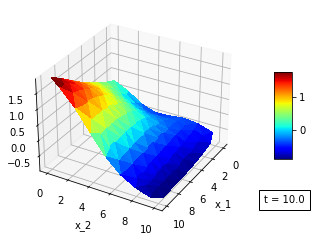

In [90]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=domain_x, n_points=150, device='cpu',
                                       data_for_other_variables={'t': 10.0 })
fig = tp.utils.plot(model, lambda u : u, plot_sampler)